# Universal antagonism classification on MSKCC peptide libraries

## Revised EC50 fits on the dose response data
As explained in the supplemental information section "II.3.9 Antagonism predictions for mutated peptide libraries", we had to perform our own EC50 fits on the dose response data from the paper 

> Łuksza *et al*., "Neoantigen quality predicts immunoediting in survivors of pancreatic cancer", *Nature*, 2022. 

The motivation was threefold: to ensure a consistent treatment with our own dose response measurements on the HHAT peptide library, to obtain error bars on the fitted EC50s, and to use the same parameter clipping boundaries on all peptide sets (derived from CMV, gp100, and a neoantigen). 

The script `secondary_scripts/mskcc_ec50_mcmc.py` generated these EC50 fits. Here, we additionally need to fix missing EC50s for all the weakest CMV-derived peptides, which only had their response at maximum dose measured. Discarding these peptides would create a systematic under-estimation of the fraction of potential antagonist peptides. We prevent this issue (as explained in the SI) by inferring the missing EC50s from a linear regression between the EC50 and the response at maximum dose: we perform the linear fit on all peptides for which a full dose response is available, then use the regression to infer the EC50 of missing peptides based on their maximal response. 

## Predicting antagonism
Once we have an EC50 for all peptides, we convert them to $\tau$s and use the revised AKPR model to predict the antagonism or enhancement each peptide would cause. We set antigen abundances $L^\rho$ based on measurements of CAR antigen and MHC abundance on the target tumor cells, here assumed to be PC9 tumors. 

## Strategy to generate complete prediction confidence intervals

We will propagate the following sources of uncertainty to these model predictions in particular, since there is no experimental data to confirm the model $FC$ predictions, so we want to convey the high level of uncertainty associated with these predictions, beyond just uncertainty on the best model parameter fits. 

- TCR/CAR model parameters: from MCMC samples of revised AKPR model parameter fits
- Antigen densities: assume log-normal distributions around the "average APC" on which the ODE model is based. The standard deviation of this distribution is the standard error on the statistical mean estimator. 
- Peptide affinities: from a log-normal fit on the MCMC distribution of dose response curve parameters

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json, h5py
import os

from sklearn.linear_model import LinearRegression

from utils.cpu_affinity import count_parallel_cpu
from utils.fitting import hill_with_back_diff
n_cpu = count_parallel_cpu()

In [2]:
from utils.preprocess import michaelis_menten
from models.conversion import convert_ec50_tau_relative
from mcmc.plotting import change_log_ticks
from utils.preprocess import write_conc_uM
from mcmc.costs_tcr_car_antagonism import antag_ratio_panel_tcr_car
from mcmc.ci_predictions_molec_numbers import (
    confidence_predictions_car_antagonism_ligands,
    compute_stats_ci
)
from mcmc.utilities_tcr_car_antagonism import load_tcr_car_molec_numbers_ci

In [3]:
# Choose 10 for quick test run, 1000 for adequate statistics
n_boot = 1000
do_save_plots = True
do_save_outputs = True

# Plot parameters
fig_dir_supp = os.path.join("figures", "dose_response", "mskcc_mcmc")

## Aesthetic parameters

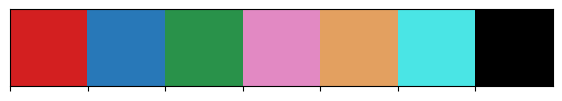

In [4]:
with open("results/for_plots/perturbations_palette.json", "r") as f:
    perturb_palette = json.load(f)
perturb_palette["None"] = [0., 0., 0., 1.]  # Black
sns.palplot(perturb_palette.values())

# Step 1: reanalyze MSKCC EC50 to obtain error bars on EC50
Will use the same least-squares fitting function detailed in their supplementary information, and will use the jacobian of that cost function at the best fit point to estimate a standard deviation on the EC50 (diagonal element of the inverse jacobian is the variance). 

## Done with MCMC

There are 1204 peptides, $32 \times 1000$ MCMC parameter samples for each: huge same file. The resulting distribution for EC50 is approximately Gaussian in log scale, so I have just fitted the standard deviation of this marginal posterior distribution, and for CI calculation will sample log-normal values of EC50 from this approximate distribution

Using the maximum a posteriori for the best model prediction line. 

In [5]:
# Fit results
df_ec50_stats = pd.read_hdf(os.path.join("results", "pep_libs", "mskcc_ec50_mcmc_stats_backgnd.h5"), key="df")
df_ec50_stats = df_ec50_stats.sort_index(axis=1).drop(["mcmc_tau", "logprob"], axis=1)

df_ec50_lsq3 = pd.read_hdf(os.path.join("results", "pep_libs", "mskcc_ec50_lsq_results_backgnd_3.h5"), key="df")
df_ec50_lsq3 = df_ec50_lsq3.drop(["V_inf_std", "n_std", "log_ec50_ugmL_std", "K_a"], axis=1)
df_ec50_lsq3 = pd.concat({"LSQ_3":df_ec50_lsq3.sort_index(axis=1)}, names=["Feature", "Parameter"], axis=1)

# Least-squares of the same full model as the MCMC simulations, to get meaningful
# Hessian estimates of parameter uncertainty
param_names5 = ["V_inf", "n", "log_ec50_ugmL", "logN_eff", "backgnd"]
stds_names5 = [a+"_std" for a in param_names5]
rename_map = dict(zip(stds_names5, param_names5))
df_ec50_lsq5 = pd.read_hdf(os.path.join("results", "pep_libs", "mskcc_ec50_lsq_results_backgnd_5.h5"), key="df")
df_ec50_lsq5 = pd.concat({"LSQ_5":df_ec50_lsq5[param_names5], "std_lsq":df_ec50_lsq5[stds_names5].rename(rename_map, axis=1)}, 
                         names=["Feature", "Parameter"], axis=1)
df_ec50_stats = pd.concat([df_ec50_stats, df_ec50_lsq3, df_ec50_lsq5], axis=1)

# Can drop everything except EC50, other code has already plotted sample fits to check quality. 
#df_ec50_stats = df_ec50_stats.xs("log_ec50_ugmL", axis=1, level="Parameter")
df_ec50_stats

Feature                   MAP                                              \
Parameter               V_inf   backgnd  logN_eff log_ec50_ugmL         n   
Antigen TCR Peptide                                                         
CMV     1   A7C           NaN       NaN       NaN           NaN       NaN   
            A7D           NaN       NaN       NaN           NaN       NaN   
            A7E           NaN       NaN       NaN           NaN       NaN   
            A7F           NaN       NaN       NaN           NaN       NaN   
            A7G      0.991831  0.056872  2.349354     -2.065310  0.086330   
...                       ...       ...       ...           ...       ...   
gp100   6   V9S      0.897688  0.000320  4.568822      4.316783  0.203153   
            V9T      0.493814  0.087352  4.914985     -0.353245  0.904868   
            V9W      0.998138  0.004631  4.707119      3.585888  1.134557   
            V9Y      0.986160  0.006064  4.732532      3.652489  1.140456   
            WT       0.999999  0.028990  4.663250     -2.739003  0.327669   

Feature                 stdev                                              \
Parameter               V_inf   backgnd  logN_eff log_ec50_ugmL         n   
Antigen TCR Peptide                                                         
CMV     1   A7C           NaN       NaN       NaN           NaN       NaN   
            A7D           NaN       NaN       NaN           NaN       NaN   
            A7E           NaN       NaN       NaN           NaN       NaN   
            A7F           NaN       NaN       NaN           NaN       NaN   
            A7G      0.128571  0.042953  0.661698      0.970181  0.582886   
...                       ...       ...       ...           ...       ...   
gp100   6   V9S      0.251403  0.035533  1.242653      1.436360  0.501016   
            V9T      0.111117  0.039518  1.232095      0.786334  0.489077   
            V9W      0.216521  0.015904  1.165654      0.663960  0.416464   
            V9Y      0.217135  0.015920  1.155883      0.660450  0.416049   
            WT       0.028190  0.043192  1.257165      0.389820  0.413224   

Feature              ...     LSQ_5                                    \
Parameter            ...     V_inf         n log_ec50_ugmL  logN_eff   
Antigen TCR Peptide  ...                                               
CMV     1   A7C      ...  0.332301       NaN           NaN       NaN   
            A7D      ...  0.284830       NaN           NaN       NaN   
            A7E      ...  0.294118       NaN           NaN       NaN   
            A7F      ...  0.024665       NaN           NaN       NaN   
            A7G      ...  1.000000  0.092531     -2.114654  1.284198   
...                  ...       ...       ...           ...       ...   
gp100   6   V9S      ...  0.894292  0.201757      4.317636  4.557524   
            V9T      ...  0.491890  0.891386     -0.394920  4.694240   
            V9W      ...  0.993816  1.135693      3.574466  4.698091   
            V9Y      ...  0.993633  1.146541      3.639797  4.697312   
            WT       ...  1.000000  0.327371     -2.738564  4.662052   

Feature                             std_lsq                                    \
Parameter                 backgnd     V_inf         n log_ec50_ugmL  logN_eff   
Antigen TCR Peptide                                                             
CMV     1   A7C               NaN  0.000000       NaN           NaN       NaN   
            A7D               NaN  0.000000       NaN           NaN       NaN   
            A7E               NaN  0.000000       NaN           NaN       NaN   
            A7F               NaN  0.000000       NaN           NaN       NaN   
            A7G      1.786010e-02  0.333293  0.117580      3.219185  1.020780   
...                           ...       ...       ...           ...       ...   
gp100   6   V9S      4.168274e-18  0.377785  0.220629      2.023022  1.997814   
            V9T      8.

In [6]:
df_raw_data_mskcc = pd.read_hdf(os.path.join("data", "dose_response", "MSKCC_rawDf.hdf"), key="df")
df_dose_mskcc = df_raw_data_mskcc.set_index(["Dose (ug/mL)"],
                drop=True, append=True).drop("Dose (M)", axis=1)
df_dose_mskcc = df_dose_mskcc.unstack(["Dose (ug/mL)"]) / 100.0
resp_name = "Response (CD137+ fraction)"
df_dose_mskcc = df_dose_mskcc.rename(
    {"Response (CD137+ %)": resp_name}, axis=1)
df_dose_mskcc[resp_name] = df_dose_mskcc[resp_name].clip(0.0, 1.0)
df_dose_mskcc = df_dose_mskcc.sort_index()

tcr_set = df_dose_mskcc.index.get_level_values("TCR").unique().sort_values()
tcr_to_ag_map = {}
for tcr in tcr_set: 
    tcr_to_ag_map[tcr] = df_dose_mskcc.xs(tcr, level="TCR").index.get_level_values("Antigen")[0]
print(tcr_to_ag_map)

{'1': 'CMV', '2': 'CMV', '3': 'CMV', '4': 'gp100', '5': 'gp100', '6': 'gp100', '7': 'Neoantigen'}


### Plot difference between our fits and the original ones

In [7]:
def change_identity_for_wt(df):
    """ For a DataFrame of peptides, for each TCR, change a
    peptide which is unmutated for 'WT' and drop duplicates """
    df2 = df.copy()
    for ag, tcr, pep in df.index:
        if pep[0] == pep[2]:  # This is WT
            df2 = df2.rename({pep:"WT"}, level="Peptide", axis=0)
            
    df2 = df2.loc[~df2.index.duplicated(keep='first')].sort_index()
    return df2

In [8]:
# Compare fit results to those provided by MSKCC
df_fits_mskcc = pd.read_hdf("data/dose_response/MSKCC_fitCurvesEC50.hdf", key="df")
df_fits_mskcc[np.isinf(df_fits_mskcc)] = np.nan
# They say they clip and they provide large values... There is some crap for sure in that dataset
df_fits_mskcc["K_a"] = df_fits_mskcc["K_a"].clip(lower=1e-4, upper=1e4)
df_fits_mskcc["log_ec50_ugmL"] = np.log10(df_fits_mskcc["K_a"])
df_fits_mskcc = df_fits_mskcc.rename({"A":"V_inf"}, axis=1)
df_fits_mskcc = df_fits_mskcc.rename({"Neopeptide":"Neoantigen"}, axis=0, level="Antigen")
p_keep = ["V_inf", "n", "K_a", "log_ec50_ugmL"]
df_fits_mskcc = df_fits_mskcc[p_keep]
df_fits_mskcc = change_identity_for_wt(df_fits_mskcc)
df_fits_mskcc.dropna()

Parameter               V_inf         n          K_a  log_ec50_ugmL
Antigen TCR Peptide                                                
CMV     1   A7G      1.000000  0.094410     0.012426      -1.905660
            A7P      0.543922  0.865218     0.293006      -0.533124
            A7S      0.950017  0.143824     0.563531      -0.249082
            L2A      1.000000  0.153339     2.806474       0.448161
            L2C      0.824717  0.406109     0.034538      -1.461697
...                       ...       ...          ...            ...
gp100   6   V9S      0.223357  0.957663     0.649477      -0.187436
            V9T      0.499263  0.577499     0.159280      -0.797838
            V9W      0.999234  0.999453  6107.575463       3.785869
            V9Y      0.999191  0.999659  7483.763717       3.874120
            WT       1.000000  0.378867     0.002511      -2.600156

[990 rows x 4 columns]

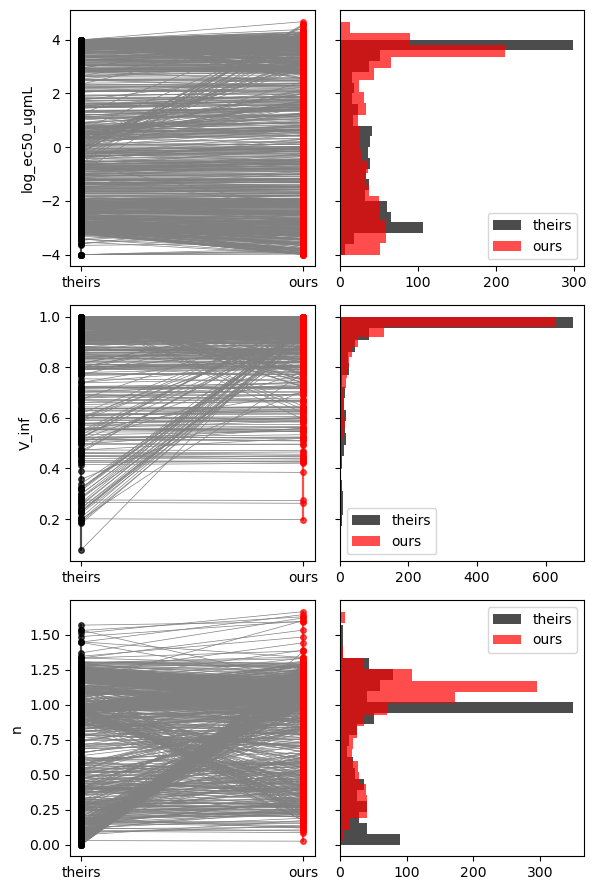

In [9]:
df_ours_theirs = pd.concat({"ours":df_ec50_stats["MAP"], "theirs":df_fits_mskcc}, axis=1, names=["Source"])
df_ours_theirs = df_ours_theirs.sort_index(axis=1).sort_index(axis=0)

fig, axes = plt.subplots(3, 2, sharey="row")
fig.set_size_inches(6, 9)
xlabels = ["theirs", "ours"]
for i, p in enumerate(["log_ec50_ugmL", "V_inf", "n"]):
    yvals = df_ours_theirs.xs(p, level="Parameter", axis=1).dropna()
    axes[i, 0].plot(
        np.arange(2).reshape(2, 1), yvals[xlabels].values.T, 
        ls="-", color="grey", lw=0.5
    )
    npeps = yvals.shape[0]
    axes[i, 0].plot(np.zeros(npeps), yvals[xlabels[0]].values, marker="o", color="k", ms=4, alpha=0.7)
    axes[i, 0].plot(np.ones(npeps), yvals[xlabels[1]].values, marker="o", color="r", ms=4, alpha=0.7)
    axes[i, 0].set_xticks(np.arange(2))
    axes[i, 0].set_xticklabels(xlabels)
    axes[i, 0].set_ylabel(p)
    
    # Now histograms or KDEs
    hist_ours, edges_ours = np.histogram(yvals["ours"].values, bins=20)
    hist_theirs, edges_theirs = np.histogram(yvals["theirs"].values, bins=20)
    axes[i, 1].barh(y=edges_theirs[:-1], width=hist_theirs, height=np.diff(edges_theirs), 
                    align="edge", color="k", alpha=0.7, label="theirs")
    axes[i, 1].barh(y=edges_ours[:-1], width=hist_ours, height=np.diff(edges_ours), 
                    align="edge", color="r", alpha=0.7, label="ours")
    axes[i, 1].legend()
fig.tight_layout()
plt.show()
plt.close()

In [10]:
# One example where their EC50 and ours are very different. 
# But this is a very weak peptide, response near zero, so 
# the EC50 should be large: ours is better. 
df_ours_theirs.loc[("gp100", "6", "V9S")]

Source  Parameter    
ours    V_inf            0.897688
        backgnd          0.000320
        logN_eff         4.568822
        log_ec50_ugmL    4.316783
        n                0.203153
theirs  K_a              0.649477
        V_inf            0.223357
        log_ec50_ugmL   -0.187436
        n                0.957663
Name: (gp100, 6, V9S), dtype: float64

## 1.2 Convert EC50s in mass/volume to EC50s in molar units
Also convert the standard deviations (error bars). 

Sooraj did (in Colab) the calculation for each peptide using molecular weights of amino acids; I can just compare the Dose (M) and Dose (ug/mL) values for each peptide in the raw Df and infer the scaling factor for each peptide separately. 

Neglecting any uncertainty on these factors and on the molecular weights, they are negligible compared to biological and parameter estimation sources of uncertainty. 

In [11]:
df_for_ratio = df_raw_data_mskcc.set_index("Dose (ug/mL)", append=True, drop=False)
weight_conv_factors = df_for_ratio["Dose (M)"] / df_for_ratio['Dose (ug/mL)']
weight_conv_factors = weight_conv_factors.xs(100.0, level="Dose (ug/mL)")
print("Number of unique conversion factors:", np.unique(weight_conv_factors.dropna().values).size)
print("Versus number of peptides with ug/ML EC50s:", weight_conv_factors.dropna().shape[0])
weight_conv_factors

Number of unique conversion factors: 176
Versus number of peptides with ug/ML EC50s: 1204


Antigen     TCR  Peptide
CMV         1    N1A        9.587728e-07
                 N1C        9.302326e-07
                 N1D        9.199632e-07
                 N1E        9.082652e-07
                 N1F        8.936550e-07
                                ...     
            3    WT         9.208103e-07
Neoantigen  7    WT         8.424600e-07
gp100       4    WT         8.488964e-07
            5    WT         8.488964e-07
            6    WT         8.488964e-07
Length: 1204, dtype: float64

In [12]:
for lvl in df_ec50_stats.columns.get_level_values("Feature").unique():
    # log(K * factor) = log(K) + log(factor). Base is log_10
    # Standard deviation in log-scale remains the same: log(ugml * scale) = log(ugml) + constant
    # the constant does not contribute to the standard deviation
    if lvl == "stdev" or lvl == "std_lsq": 
        df_ec50_stats.loc[:, (lvl, "log_ec50_M")] = df_ec50_stats.loc[:, (lvl, "log_ec50_ugmL")]
    else:
        df_ec50_stats.loc[:, (lvl, "log_ec50_M")] = (df_ec50_stats.loc[:, (lvl, "log_ec50_ugmL")]
                                                    + np.log10(weight_conv_factors))
df_ec50_stats.sort_index(axis=1).dropna()

Feature                 LSQ_3                                        LSQ_5  \
Parameter               V_inf log_ec50_M log_ec50_ugmL         n     V_inf   
Antigen TCR Peptide                                                          
CMV     1   A7G      1.000000  -8.387147     -2.356953  0.083425  1.000000   
            A7P      0.542141  -6.605034     -0.558929  0.853155  0.543199   
            A7S      0.677535  -7.955594     -1.913413  0.281838  0.900359   
            L2A      1.000000  -5.570539      0.448161  0.153339  1.000000   
            L2C      0.809610  -7.577475     -1.545662  0.427202  0.829291   
...                       ...        ...           ...       ...       ...   
gp100   6   V9S      0.544134  -3.605112      2.461586  0.254611  0.894292   
            V9T      0.492682  -6.938479     -0.866597  0.588044  0.491890   
            V9W      0.946944  -2.825379      3.276712  1.142138  0.993816   
            V9Y      0.946434  -2.798905      3.295217  1.146003  0.993633   
            WT       1.000000  -8.767230     -2.696084  0.355874  1.000000   

Feature                                                               \
Parameter                 backgnd  logN_eff log_ec50_M log_ec50_ugmL   
Antigen TCR Peptide                                                    
CMV     1   A7G      1.786010e-02  1.284198  -8.144848     -2.114654   
            A7P      2.301915e-02  4.695306  -6.506157     -0.460052   
            A7S      5.715876e-26  4.674907  -6.657297     -0.615115   
            L2A      1.500000e-01  1.342195  -4.757837      1.260863   
            L2C      1.630707e-02  4.698459  -7.465199     -1.433387   
...                           ...       ...        ...           ...   
gp100   6   V9S      4.168274e-18  4.557524  -1.749062      4.317636   
            V9T      8.355151e-02  4.694240  -6.466802     -0.394920   
            V9W      4.181141e-03  4.698091  -2.527624      3.574466   
            V9Y      5.302417e-03  4.697312  -2.454325      3.639797   
            WT       2.969176e-02  4.662052  -8.809710     -2.738564   

Feature                        ...   std_lsq                           \
Parameter                   n  ...  logN_eff log_ec50_M log_ec50_ugmL   
Antigen TCR Peptide            ...                                      
CMV     1   A7G      0.092531  ...  1.020780   3.219185      3.219185   
            A7P      0.946521  ...  1.999997   0.584755      0.584755   
            A7S      0.149963  ...  1.998943   2.952902      2.952902   
            L2A      0.241819  ...  1.112224   2.446556      2.446556   
            L2C      0.387988  ...  2.000000   0.917340      0.917340   
...                       ...  ...       ...        ...           ...   
gp100   6   V9S      0.201757  ...  1.997814   2.023022      2.023022   
            V9T      0.891386  ...  1.999997   0.586463      0.586463   
            V9W      1.135693  ...  1.999998   1.674137      1.674137   
            V9Y      1.146541  ...  1.999993   1.829426      1.829426   
            WT       0.327371  ...  1.999940   0.789105      0.789105   

Feature                           stdev                                 \
Parameter                   n     V_inf   backgnd  logN_eff log_ec50_M   
Antigen TCR Peptide                                                      
CMV     1   A7G      0.117580  0.128571  0.042953  0.661698   0.970181   
            A7P      0.963759  0.073244  0.032506  1.255684   0.482623   
            A7S      0.098150  0.128914  0.042831  1.197994   1.016773   
            L2A      0.233408  0.156208  0.043287  0.654465   1.534382   
            L2C      0.172774  0.077003  0.043546  1.237516   0.455889   
...                       ...       ...       ...       ...        ...   
gp100   6   V9S      0.220629  0.251403  0.035533  1.242653   1.436360   
            V9T      0.974030  0.111117  0.039518  1.232095   0.786334   
            V9W      0.949505  0.216521  0.015904  1.165654  

## 1.3 Apply correction based on max response for missing EC50s 

Important bias: the 2022 paper did not measure full EC50 curves for all CMV-derived peptides (and only for CMV) with response below ~50 % at max. dose. This removes most potential antagonists and severely biases the distribution. **It is not fair to set these peptides to infinite EC50 as if they were null, because they do produce a lot of response**. So, we need to correct these missing EC50s, or drop CMV altogether. 

For these peptides with only one dose tested, we can infer EC50 (in M) without fitting a Hill curve by regressing the max response against the EC50 for fitted peptides, then using this linear regression fit to estimate the EC50 of peptides with only one max. dose response. 

Give these peptides a bigger uncertainty, based on the linear regression uncertainty: yet another propagation step, this gets complicated even statistically. 

In [13]:
# Function to get a CI on the inferred EC50s
from utils.fitting import (
    student_t_predict_interval_linregress, 
    student_t_confid_interval_linregress
)

### Illustrating the bias that missing EC50s are all for the weakest peptides. 



In [14]:
df_mut2 = df_fits_mskcc["K_a"]
df_mut2.name = "ec50_M"
df_mut2 = df_mut2.to_frame()

peps_with_inf = np.isnan(df_mut2)
df_plot = df_raw_data_mskcc.copy().xs("CMV", level="Antigen")
df_plot["not_measured_inf"] = peps_with_inf.xs("CMV", level="Antigen")

ec50_threshold_antagonists = 1e-3
avg_max_response_antagonists = df_mut2[df_mut2["ec50_M"] < ec50_threshold_antagonists]

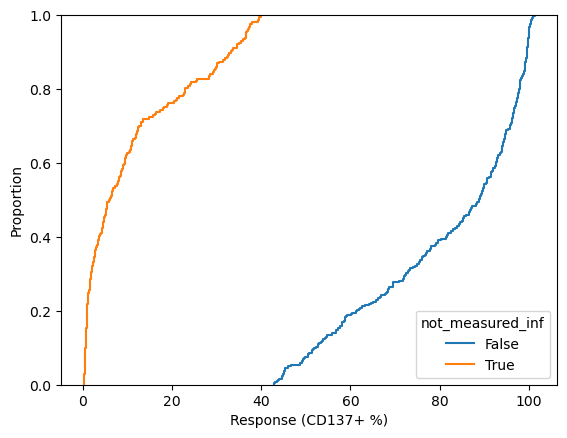

In [15]:
sns.ecdfplot(data=df_plot.loc[df_plot["Dose (ug/mL)"] == 100.0].reset_index(), 
             x="Response (CD137+ %)", hue="not_measured_inf")
plt.show()
plt.close()

### Fitting EC50s vs maximum response

In [16]:
choice_ec = "log_ec50_M"  #"EC50 (M)"  #'EC50 (ug/mL)'
choice_method = "MAP"
choice_std = "std_lsq" if choice_method.startswith("LSQ") else "stdev"
if choice_ec == 'log_ec50_M':
    noINF = df_ec50_stats[(choice_method, choice_ec)].copy()
elif choice_ec == "EC50 (ug/mL)":
    noINF = df_fits_mskcc.copy()["K_a"]
elif choice_ec == "EC50 (M)":
    noINF = df_fits_mskcc.copy()["K_a"] * weight_conv_factors
noINF.name = choice_ec

noINF2 = df_raw_data_mskcc[df_raw_data_mskcc['Dose (ug/mL)'] == 100]
noINF = pd.concat([noINF,noINF2],axis=1)
noINF = noINF[~np.isnan(noINF[choice_ec])]
if choice_ec.startswith("log"):
    noINF["EC50 (M)"] = 10.0**noINF[choice_ec]
noINF = noINF[noINF[choice_ec] != np.inf]
noINF = noINF.rename({"Response (CD137+ %)": resp_name}, axis=1)
noINF[resp_name] /= 100.0
noINF

log_ec50_M  Dose (ug/mL)  Dose (M)  \
Antigen TCR Peptide                                       
CMV     1   A7G       -8.095505         100.0  0.000093   
            A7P       -6.497299         100.0  0.000090   
            A7S       -6.563639         100.0  0.000091   
            L2A       -4.843490         100.0  0.000096   
            L2C       -7.455517         100.0  0.000093   
...                         ...           ...       ...   
gp100   6   V9S       -1.749916         100.0  0.000086   
            V9T       -6.425127         100.0  0.000085   
            V9W       -2.516203         100.0  0.000079   
            V9Y       -2.441633         100.0  0.000081   
            WT        -8.810148         100.0  0.000085   

                     Response (CD137+ fraction)      EC50 (M)  
Antigen TCR Peptide                                            
CMV     1   A7G                        0.759546  8.025927e-09  
            A7P                        0.535604  3.182004e-07  
            A7S                        0.633643  2.731246e-07  
            L2A                        0.694530  1.433872e-05  
            L2C                        0.791538  3.503345e-08  
...                                         ...           ...  
gp100   6   V9S                        0.213139  1.778625e-02  
            V9T                        0.483212  3.757275e-07  
            V9W                        0.016058  3.046472e-03  
            V9Y                        0.013139  3.617157e-03  
            WT                         1.000000  1.548287e-09  

[990 rows x 5 columns]

0.8186944473621776


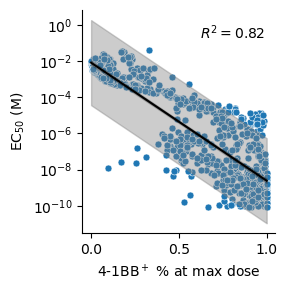

In [17]:
plottingDf = noINF.copy()
plottingDf[resp_name] = np.clip(plottingDf[resp_name],a_min=0,a_max=1.0)
if choice_ec == "EC50 (ug/mL)":
    plottingDf[choice_ec] = np.clip(plottingDf[choice_ec],a_min=-np.inf,a_max=1e5)
    #plottingDf = plottingDf[plottingDf['EC50 (M)'] <= 10**5]
elif choice_ec == "EC50 (M)":
    plottingDf[choice_ec] = np.clip(plottingDf[choice_ec],a_min=-np.inf,a_max=1e5*weight_conv_factors.mean())

X = plottingDf[resp_name].values.reshape(-1,1)
if choice_ec.startswith("log"):
    y = plottingDf[choice_ec].values.reshape(-1,1)
elif choice_ec.startswith("EC50"):
    y = np.log10(plottingDf[choice_ec].values.reshape(-1,1))
reg = LinearRegression().fit(X, y)
regscore = reg.score(X, y)
y_label = (r"EC$_{50}$ (M)" if (choice_ec.endswith("M") or choice_ec.endswith("M)"))
        else r"EC$_{50}$ (ug/mL)")
y_feature = "EC50 (M)" if choice_ec in ["log_ec50_M", "EC50 (M)"] else "EC50 (ug/mL)"
g = sns.relplot(data=plottingDf,x=resp_name,y=y_feature, s=25)
g.set(yscale='log', xlabel=r"4-1BB$^+$ % at max dose",
      ylabel=y_label)
# Plot the regression line too
xrange = np.linspace(X.min(), X.max(), 200)
yrange = 10.0**(reg.coef_[0]*xrange + reg.intercept_)
g.ax.plot(xrange, yrange, color="k")
g.ax.annotate(r"$R^2 = {:.2f}$".format(regscore), xy=(0.95, 0.9),
              xycoords="axes fraction", ha="right", va="center")
print(regscore)

# Also show the confidence interval (not the prediction interval) of the fit
mean_x = X.mean()
sum_x_resids = np.sum((X - mean_x)**2)
sample_vari_fit = np.sum((y - reg.predict(X))**2) / (X.size - 2)
confid = student_t_confid_interval_linregress(
    x=xrange, alpha=0.05, ndf=X.size, mean_x_estim=mean_x, vari_estim=sample_vari_fit, 
    ssx=sum_x_resids, slope=reg.coef_[0], intercept=reg.intercept_
)
pred = student_t_predict_interval_linregress(
    x=xrange, alpha=0.05, ndf=X.size, mean_x_estim=mean_x, vari_estim=sample_vari_fit, 
    ssx=sum_x_resids, slope=reg.coef_[0], intercept=reg.intercept_
)

y_confid_lo = reg.coef_[0]*xrange + reg.intercept_ - confid
y_confid_up = y_confid_lo + 2*confid
y_pred_lo = reg.coef_[0]*xrange + reg.intercept_ - pred
y_pred_up = y_pred_lo + 2*pred
g.ax.fill_between(xrange, 10.0**y_pred_lo, 10.0**y_pred_up, color="grey", alpha=0.4)
g.ax.fill_between(xrange, 10.0**y_confid_lo, 10.0**y_confid_up, color="k", alpha=0.2)

g.figure.set_size_inches(3, 3)
g.figure.tight_layout()
if do_save_plots:
    g.figure.savefig(os.path.join(fig_dir_supp, "supfig_maxresponse_vs_ec50s.pdf"),
                    transparent=True, bbox_inches="tight")

plt.show()
plt.close()



In [18]:
# Save the linear regression data and parameters for Sooraj
X = plottingDf[resp_name]
if choice_ec.startswith("log"):
    y = plottingDf[choice_ec]
    ylbl = choice_ec
elif choice_ec.startswith("EC50"):
    y = np.log10(plottingDf[choice_ec])
    ylbl = "log_" + choice_ec
regressionDf = pd.concat({resp_name:X, ylbl:y}, axis=1, names=["Variable"])
regressionFName = os.path.join("results", "pep_libs", "mskcc_ec50s_maxresponse_regression.h5")
if do_save_outputs:
    regressionDf.to_hdf(regressionFName, key="data")

# Save the linear regression parameters too
paramsSeries = pd.Series([reg.coef_[0, 0], reg.intercept_[0]], 
    index=pd.Index(["slope", "intercept"], name="Parameter"), name="regression")
paramsSeries
if do_save_outputs:
    paramsSeries.to_hdf(regressionFName, key="regression")

### Inferring missing EC50s
Use the prediction confidence interval of the linear regression

In [19]:
if choice_ec == 'log_ec50_M':
    withINF = df_ec50_stats[(choice_method, choice_ec)].copy()
elif choice_ec == "EC50 (ug/mL)":
    withINF = df_fits_mskcc.copy()["K_a"]
elif choice_ec == "EC50 (M)":
    withINF = df_fits_mskcc.copy()["K_a"] * weight_conv_factors
withINF.name = choice_ec

withINF2 = df_raw_data_mskcc[df_raw_data_mskcc['Dose (ug/mL)'] == 100]
withINF = pd.concat([withINF,withINF2],axis=1)
withINF = withINF[np.isnan(withINF[choice_ec])]
if choice_ec.startswith("log"):
    withINF["EC50 (M)"] = 10.0**withINF[choice_ec]
withINF = withINF.rename({"Response (CD137+ %)": resp_name}, axis=1)
withINF[resp_name] /= 100.0

withINF[choice_ec] = reg.coef_[0]*withINF[resp_name] + reg.intercept_
# Get a CI, divide by the Student's t critical value to get the std
withINF[choice_ec + "_log_std"] = student_t_predict_interval_linregress(
    withINF[choice_ec], 0.05, ndf=X.size, mean_x_estim=mean_x, vari_estim=sample_vari_fit, 
    ssx=sum_x_resids, slope=reg.coef_[0], intercept=reg.intercept_)
withINF[choice_ec + "_log_std"]  /= sp.stats.t.ppf(q=1.0 - 0.05/2.0, df=X.size-2)
if choice_ec.startswith("EC50"):
    withINF[choice_ec] = 10.0**withINF[choice_ec]
else:
    withINF["EC50 (M)"] = 10.0**withINF[choice_ec]
display(withINF)

log_ec50_M  Dose (ug/mL)  Dose (M)  \
Antigen TCR Peptide                                       
CMV     1   A7C       -4.253609         100.0  0.000089   
            A7D       -3.943262         100.0  0.000088   
            A7E       -4.003982         100.0  0.000087   
            A7F       -2.242425         100.0  0.000086   
            A7H       -3.659902         100.0  0.000087   
...                         ...           ...       ...   
        3   V6E       -2.357691         100.0  0.000090   
            V6F       -2.193101         100.0  0.000088   
            V6H       -2.634203         100.0  0.000089   
            V6N       -3.549325         100.0  0.000091   
            V6P       -4.503950         100.0  0.000092   

                     Response (CD137+ fraction)  EC50 (M)  log_ec50_M_log_std  
Antigen TCR Peptide                                                            
CMV     1   A7C                        0.332301  0.000056            1.284316  
            A7D                        0.284830  0.000114            1.273656  
            A7E                        0.294118  0.000099            1.275692  
            A7F                        0.024665  0.005722            1.227002  
            A7H                        0.241486  0.000219            1.264482  
...                                         ...       ...                 ...  
        3   V6E                        0.042296  0.004388            1.229508  
            V6F                        0.017120  0.006411            1.225960  
            V6H                        0.084592  0.002322            1.235918  
            V6N                        0.224572  0.000282            1.261050  
            V6P                        0.370594  0.000031            1.293370  

[214 rows x 6 columns]

In [20]:
# Put back the results in the stats dataframe
df_ec50_stats_treat = df_ec50_stats.copy()
df_ec50_stats_treat.loc[withINF.index, (choice_method, choice_ec)] = withINF[choice_ec]
df_ec50_stats_treat.loc[withINF.index, (choice_std, choice_ec)] = withINF[choice_ec + "_log_std"]
# Also put back the ug/mL corresponding EC50s
df_ec50_stats_treat.loc[withINF.index, (choice_method, "log_ec50_ugmL")] = (
    df_ec50_stats_treat.loc[withINF.index, (choice_method, "log_ec50_M")] 
    - np.log10(weight_conv_factors.loc[withINF.index])
)

# Also set the maximum response as the amplitude, and background to zero, n to 1, N_eff to 1e3 (large error)
df_ec50_stats_treat.loc[withINF.index, (choice_method, "backgnd")] = 0.0
df_ec50_stats_treat.loc[withINF.index, (choice_method, "V_inf")] = withINF[resp_name]
df_ec50_stats_treat.loc[withINF.index, (choice_method, "n")] = 1.0
df_ec50_stats_treat.loc[withINF.index, (choice_method, "logN_eff")] = 3
df_ec50_stats_treat = df_ec50_stats_treat.sort_index(axis=0).sort_index(axis=1)
df_ec50_stats_treat[choice_method]

Parameter               V_inf   backgnd  logN_eff  log_ec50_M  log_ec50_ugmL  \
Antigen TCR Peptide                                                            
CMV     1   A7C      0.332301  0.000000  3.000000   -4.253609       1.794833   
            A7D      0.284830  0.000000  3.000000   -3.943262       2.109816   
            A7E      0.294118  0.000000  3.000000   -4.003982       2.054444   
            A7F      0.024665  0.000000  3.000000   -2.242425       3.822781   
            A7G      0.991831  0.056872  2.349354   -8.095505      -2.065310   
...                       ...       ...       ...         ...            ...   
gp100   6   V9S      0.897688  0.000320  4.568822   -1.749916       4.316783   
            V9T      0.493814  0.087352  4.914985   -6.425127      -0.353245   
            V9W      0.998138  0.004631  4.707119   -2.516203       3.585888   
            V9Y      0.986160  0.006064  4.732532   -2.441633       3.652489   
            WT       0.999999  0.028990  4.663250   -8.810148      -2.739003   

Parameter                   n  
Antigen TCR Peptide            
CMV     1   A7C      1.000000  
            A7D      1.000000  
            A7E      1.000000  
            A7F      1.000000  
            A7G      0.086330  
...                       ...  
gp100   6   V9S      0.203153  
            V9T      0.904868  
            V9W      1.134557  
            V9Y      1.140456  
            WT       0.327669  

[1204 rows x 6 columns]

## 1.4 Ensure non-responsive peptides are either null or antagonists
In lack of a measurable dose response, it's impossible to tell whether a peptide will be an antagonist or a completely null peptide. 

So, for peptides with maximum response too small, or amplitude of response above background too small, or EC50 very close to the maximum, set their EC50 half-way between a completely null EC50 (ensuring $\tau \approx 0$) and their fitted EC50, and increase their standard deviation such that when sampling EC50s, they can be either antagonists or null. 

In [21]:
# non-responsive peptides: max response < 15 % (which is the max. background)
# and difference in response between min and max doses (in the curve fit) < 0.02
max_ec50_found = df_ec50_stats[(choice_method, "log_ec50_ugmL")].max()
max_ec50_found_M = df_ec50_stats[(choice_method, "log_ec50_M")].max()
p_best_fits = df_ec50_stats.loc[:, (choice_method, ["V_inf", "n", "log_ec50_ugmL", "backgnd"])]
resp_difference = pd.Series(0.0, index=df_ec50_stats.index)
max_resp = pd.Series(0.0, index=df_ec50_stats.index)
for k in resp_difference.index:
    max_resp.loc[k] = hill_with_back_diff(2.0, p_best_fits.loc[k].values)
    resp_difference.loc[k] = max_resp.loc[k] - hill_with_back_diff(-2.0, p_best_fits.loc[k].values)

# Compute a list of non-responsive peptides based on the following criteria
resp_difference_thresh = 0.04  # Error bar I used, makes sense as a threshold
max_resp_thresh = 0.2
no_response_peps = ((resp_difference < resp_difference_thresh) & (max_resp < max_resp_thresh))
#    & (df_ec50_stats.loc[:, (choice_method, "log_ec50_ugmL")] > (max_ec50_found - 1.0)))

print("Max log10(EC50):", max_ec50_found, "ug/mL")
print("Max log10(EC50) in M:", max_ec50_found_M, "M")
#print("Found {} null peptides".format(no_response_peps.sum()), 
#      "with EC50 near max. and difference in response < 1 % cells")
print("Found {} null peptides".format(no_response_peps.sum()), 
      "with max. response < {} %".format(100.0 * max_resp_thresh), 
      "and difference in response < {} % cells".format(100.0*resp_difference_thresh))
print("Setting their EC50 to a large value ensuring their tau < 0.1 s")
print("And setting the std of these EC50s to a correspondingly large value")

# Treat these peptides
do_treat_null = True
if do_treat_null:
    max_null_ec50 = 3.0
    new_null_ec50 = 0.5 * (max_null_ec50 + df_ec50_stats.loc[no_response_peps, (choice_method, "log_ec50_M")])
    #new_null_ec50 = max_null_ec50
    df_ec50_stats_treat.loc[no_response_peps, (choice_method, "log_ec50_M")] = new_null_ec50
    df_ec50_stats_treat.loc[no_response_peps, (choice_method, "log_ec50_ugmL")] = (
        new_null_ec50 - np.log10(weight_conv_factors.loc[no_response_peps]))

    # The original fit and the max EC50 are both two standard deviations away from the assigned value.  
    diff_to_fit = (max_null_ec50 - new_null_ec50) * 0.5
    df_ec50_stats_treat.loc[no_response_peps, (choice_std, "log_ec50_M")] = np.abs(diff_to_fit)
    df_ec50_stats_treat.loc[no_response_peps, (choice_std, "log_ec50_ugmL")] = np.abs(diff_to_fit)
df_ec50_stats_treat["MAP"]

Max log10(EC50): 4.674053070232803 ug/mL
Max log10(EC50) in M: -1.3904049189941148 M
Found 308 null peptides with max. response < 20.0 % and difference in response < 4.0 % cells
Setting their EC50 to a large value ensuring their tau < 0.1 s
And setting the std of these EC50s to a correspondingly large value


Parameter               V_inf   backgnd  logN_eff  log_ec50_M  log_ec50_ugmL  \
Antigen TCR Peptide                                                            
CMV     1   A7C      0.332301  0.000000  3.000000   -4.253609       1.794833   
            A7D      0.284830  0.000000  3.000000   -3.943262       2.109816   
            A7E      0.294118  0.000000  3.000000   -4.003982       2.054444   
            A7F      0.024665  0.000000  3.000000   -2.242425       3.822781   
            A7G      0.991831  0.056872  2.349354   -8.095505      -2.065310   
...                       ...       ...       ...         ...            ...   
gp100   6   V9S      0.897688  0.000320  4.568822   -1.749916       4.316783   
            V9T      0.493814  0.087352  4.914985   -6.425127      -0.353245   
            V9W      0.998138  0.004631  4.707119    0.241899       6.343989   
            V9Y      0.986160  0.006064  4.732532    0.279184       6.373305   
            WT       0.999999  0.028990  4.663250   -8.810148      -2.739003   

Parameter                   n  
Antigen TCR Peptide            
CMV     1   A7C      1.000000  
            A7D      1.000000  
            A7E      1.000000  
            A7F      1.000000  
            A7G      0.086330  
...                       ...  
gp100   6   V9S      0.203153  
            V9T      0.904868  
            V9W      1.134557  
            V9Y      1.140456  
            WT       0.327669  

[1204 rows x 6 columns]

## Plot the final dose response fits
Including the missing, inferred EC50s. These fits will be worse, but just checking that there is nothing ludicrous coming out of them. 

In [22]:
def hill_norm(x, p3):
    a, n, k = p3
    return a / (1.0 + 10.0 ** (n * (k - x)))

In [23]:
def recover_wt_pep_seq(mut_pep_set):
    # Remove "WT", not useful to reconstruct sequence
    try:
        mut_pep_set.remove("WT")
    except:
        pass
    # From the list of all peptide mutants in form XiY, keep just the Xi
    # elements, which indicate amino acid X is at position i-1 in WT sequence
    pep_marks = np.unique(list(map(lambda x: x[:2], mut_pep_set)))
    wt_pep_seq = [""] * len(pep_marks)
    for m in pep_marks:
        aa, pos = m[0], int(m[1]) - 1
        if wt_pep_seq[pos] != "":
            raise ValueError("Conflicting amino acids in position"
                +"{}: {} and {}".format(pos, aa, wt_pep_seq[pos])
            )
        else:
            wt_pep_seq[pos] = aa
    return "".join(wt_pep_seq)

In [24]:
# Plot the LSQ or MAP fits and the data
def full_plots_fits(df_data, df_fit, pep_name=""):
    """ Plot all TCRs and peptides for one antigen """
    # Prepare line styles
    amino_acids = np.unique(list("".join(df_data.index.get_level_values("Peptide").unique())))
    amino_acids = sorted([a for a in amino_acids if a.isalpha()])
    colors = sns.color_palette(n_colors=len(amino_acids))
    colors = {amino_acids[i]:colors[i] for i in range(len(amino_acids))}
    colors["WT"] = (0.0,)*3  # black for WT
    lstyles = {amino_acids[i]:("-" if i < 10 else "--") for i in range(len(amino_acids))}
    lstyles["WT"] = "-"
    markers = {amino_acids[i]:("o" if i < 10 else "^") for i in range(len(amino_acids))}
    markers["WT"] = "s"
    
    tcr_subset = df_data.index.get_level_values("TCR").unique().sort_values()
    x_doses = np.log10(df_data.columns.get_level_values("Dose (ug/mL)").astype(float).values)
    
    sub_col_map = {}
    all_mut_peps = list(df_fit.index.get_level_values("Peptide").unique())
    wt_pep_seq = recover_wt_pep_seq(all_mut_peps)
    n_rows = len(tcr_subset)
    n_cols = len(wt_pep_seq)
    resp_name = "Response (% CD137+)"
    
    # Determine Hill model fitted
    if "backgnd" in df_fit.columns:
        dose_fct = hill_with_back_diff
        param_names = ["V_inf", "n", "log_ec50_ugmL", "backgnd"]
    else:
        dose_fct = hill_norm
        param_names = ["V_inf", "n", "log_ec50_ugmL"]
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
    axes = np.atleast_2d(axes)
    x_range = np.linspace(-2, 2, 101)  # log conc.
    
                
    for i, tcr in enumerate(tcr_subset):
        pep_set = df_fit.xs(tcr, level="TCR").index.get_level_values("Peptide").unique()
        axes[i, 0].set_ylabel("TCR {}".format(tcr) + "\n" + resp_name)
        for jj, pep in enumerate(pep_set):
            y_responses = df_data.loc[(tcr, pep), :].values
            params = df_fit.loc[(tcr, pep), param_names].values
            # Error bars from N_eff
            errors = np.sqrt(y_responses * (1.0 - y_responses) / 10.0**df_fit.at[(tcr, pep), "logN_eff"])
            if np.any(np.isnan(errors)):
                errors = 0.0
            # Special case: this is the WT peptide, draw in all columns
            if pep == "WT" or pep[0] == pep[-1]:
                for j in range(n_cols):
                    clr = colors["WT"]
                    axes[i, j].errorbar(x_doses, y_responses, yerr=errors, 
                        marker="o", ls="none", mfc=clr, mec=clr, label="WT", ecolor=clr)
                    axes[i, j].plot(x_range, dose_fct(x_range, params), 
                        color=clr, ls="-", label="WT")
                    
            # Regular case: mutated amino acid
            else:
                # Figure out in which plot to place this peptide based on the 
                # TCR and the amino acid substitution position
                # Infer the color and line style based on the substitute amino acid
                clr = colors[pep[2]]
                ls = lstyles[pep[2]]
                mark = markers[pep[2]]
                j = int(pep[1]) - 1
                axes[i, j].errorbar(x_doses, y_responses, yerr=errors,
                    marker=mark, ls="none", mfc=clr, mec=clr, ecolor=clr)
                axes[i, j].plot(x_range, dose_fct(x_range, params), 
                    color=clr, ls=ls, label=pep[2])
    # Final bits of plotting
    fig.set_size_inches(2.25 * n_cols, 2.0 * n_rows + 1.0)
    for j in range(n_cols):
        axes[0, j].set_title("Position {} (".format(j+1) + wt_pep_seq[j] + ")")
        axes[-1, j].set_xlabel(r"Dose ($\mu$g/mL)")
    axes[-1, 0].set_xticks(axes[-1, 0].get_xticks())
    log_ticks = axes[-1, 0].get_xticklabels()
    lbls = list(map(lambda x: r"$10^{" + str(x.get_text()) + "}$", log_ticks))
    axes[-1, 0].set_xticklabels(lbls)
    axes[-1, 0].set_xlim([-2.1, 2.1])
    fig.suptitle("Peptide {}: {}".format(pep_name, wt_pep_seq))
    fig.tight_layout()
    
    return fig, axes


def standalone_legend(*leg_args, **leg_kwargs):
    fig1, ax1 = plt.subplots()
    ax1.set_axis_off()
    leg1 = ax1.legend(*leg_args, **leg_kwargs)
    fig1.canvas.draw()
    # First dummy drawing to get the legend size in inches
    leg_width = leg1.get_window_extent().width / fig1.dpi
    leg_height = leg1.get_window_extent().height / fig1.dpi
    plt.close()

    # Now, actual figure which we set at the right size
    fig, ax = plt.subplots()
    fig.set_size_inches(leg_width*1.05, leg_height*1.05)
    ax.set_axis_off()
    leg = ax.legend(*leg_args, **leg_kwargs)
    fig.tight_layout()
    return fig, ax, leg

# Create a stand-alone legend for amino acid substitutions
def full_plots_legend_aa(df_data, **kwargs):
    # Prepare line styles
    amino_acids = np.unique(list("".join(df_data.index.get_level_values("Peptide").unique())))
    amino_acids = sorted([a for a in amino_acids if a.isalpha()])
    colors = sns.color_palette(n_colors=len(amino_acids))
    colors = {amino_acids[i]:colors[i] for i in range(len(amino_acids))}
    colors["WT"] = (0.0,)*3  # black for WT
    lstyles = {amino_acids[i]:("-" if i < 10 else "--") for i in range(len(amino_acids))}
    lstyles["WT"] = "-"
    markers = {amino_acids[i]:("o" if i < 10 else "^") for i in range(len(amino_acids))}
    markers["WT"] = "o"
    
    leg_handles = [mpl.lines.Line2D([0], [0], label="WT", ls="-", marker="s", color=colors["WT"])]
    for aa in amino_acids:
        leg_handles.append(mpl.lines.Line2D([0], [0], label=aa, 
            ls=lstyles[aa], marker=markers[aa], color=colors[aa]))
    return standalone_legend(handles=leg_handles, **kwargs)
    

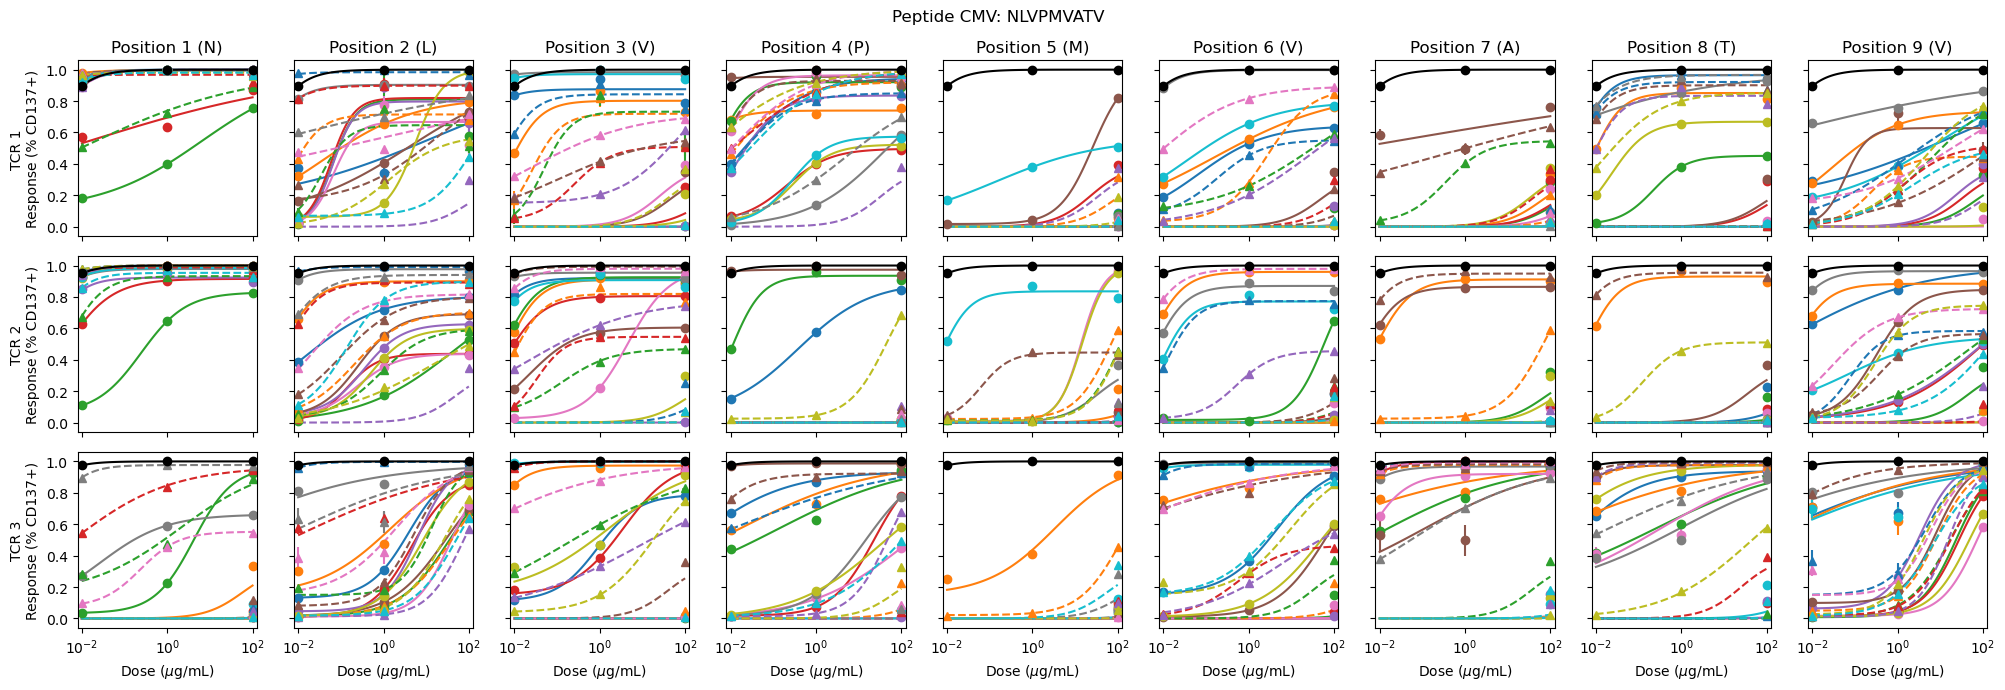

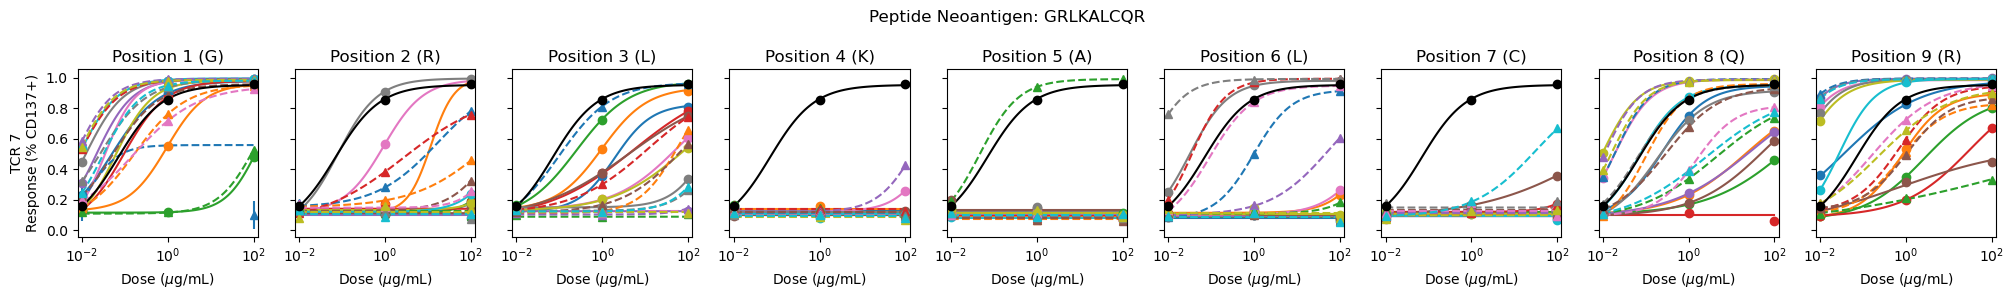

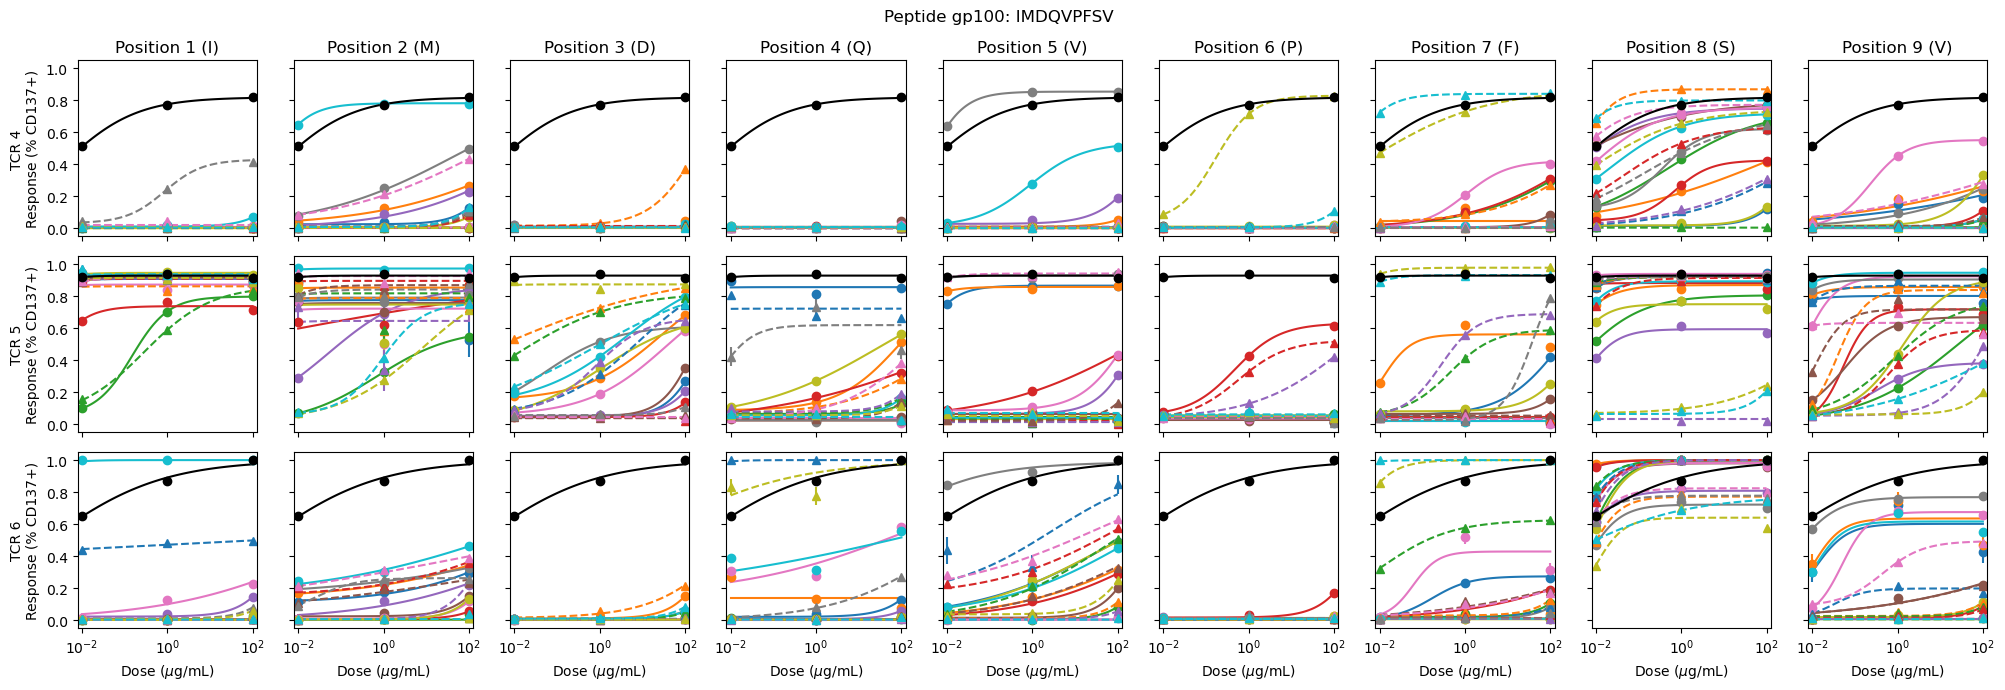

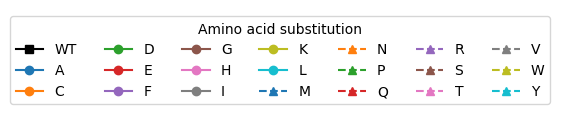

In [25]:
for ag in np.unique(list(tcr_to_ag_map.values())):
    figax = full_plots_fits(
        df_dose_mskcc.xs(ag, level="Antigen"), 
        df_ec50_stats_treat[choice_method].xs(ag, level="Antigen"), 
        pep_name=ag
    )
    if do_save_plots:
        figax[0].savefig(os.path.join("figures", "dose_response", 
            "mskcc_dose_response_MAP_fits_{}.pdf".format(ag)), transparent=True)
    plt.show()
    plt.close()
figaxes2 = full_plots_legend_aa(df_dose_mskcc.xs(ag, level="Antigen"), 
                                title="Amino acid substitution", ncols=7)
if do_save_plots:
    figaxes2[0].savefig(os.path.join("figures", "dose_response", 
            "mskcc_dose_response_substitutions_legend.pdf"), transparent=True)
plt.show()
plt.close()

In [26]:
df_ec50_stats_treat.loc[("Neoantigen", "7", ["A5P", "A5Q", "A5H", "A5Y", "A5C"])]

Feature                    LSQ_3                                        LSQ_5  \
Parameter                  V_inf log_ec50_M log_ec50_ugmL         n     V_inf   
Antigen    TCR Peptide                                                          
Neoantigen 7   A5P      0.989884  -7.426689     -1.342828  0.956936  0.991442   
               A5Q      0.246514  -3.935335      2.159485  0.102221  0.383484   
               A5H      0.255284  -4.016958      2.080993  0.045791  0.236263   
               A5Y      0.248227  -3.999539      2.107331  0.064008  0.234956   
               A5C      0.241768  -3.987874      2.098130  0.061131  0.226477   

Feature                                                                  \
Parameter                    backgnd  logN_eff log_ec50_M log_ec50_ugmL   
Antigen    TCR Peptide                                                    
Neoantigen 7   A5P      4.581058e-03  4.698954  -7.408884     -1.325023   
               A5Q      1.073643e-65  4.475560  -1.094820      5.000000   
               A5H      8.619171e-37  4.633103  -3.907509      2.190442   
               A5Y      1.365173e-36  4.627852  -3.511087      2.595784   
               A5C      9.566127e-34  4.651701  -3.602876      2.483128   

Feature                           ...   std_lsq                           \
Parameter                      n  ...  logN_eff log_ec50_M log_ec50_ugmL   
Antigen    TCR Peptide            ...                                      
Neoantigen 7   A5P      0.946703  ...  2.000000   0.570731      0.570731   
               A5Q      0.100847  ...  1.996157   3.669260      3.669260   
               A5H      0.009233  ...  1.998631   3.999212      3.999212   
               A5Y      0.029190  ...  1.998855   3.992220      3.992220   
               A5C      0.024375  ...  1.999632   3.994961      3.994961   

Feature                              stdev                                 \
Parameter                      n     V_inf   backgnd  logN_eff log_ec50_M   
Antigen    TCR Peptide                                                      
Neoantigen 7   A5P      0.357753  0.023104  0.042953  1.169639   0.268620   
               A5Q      0.249523  0.231117  0.027419  1.073798   1.378275   
               A5H      0.107517  0.237457  0.026141  1.073693   1.236964   
               A5Y      0.122658  0.233352  0.027389  1.086059   1.414146   
               A5C      0.121731  0.228881  0.026754  1.075625   1.288636   

Feature                                         
Parameter              log_ec50_ugmL         n  
Antigen    TCR Peptide                          
Neoantigen 7   A5P          0.268620  0.322045  
               A5Q          1.378275  0.465025  
               A5H          1.236964  0.470894  
               A5Y          1.414146  0.459508  
               A5C          1.288636  0.466109  

[5 rows x 28 columns]

## EC50 to $\tau$ conversion
### Reference point
They don't have N4 unfortunately. Let's assume CMV is something like N4. 

Now, a lot will depend on the choice of that reference: everything will be an antagonist if we choose that too low; nothing will be if we choose too high. So better associate CMV to something too high, so we certainly don't hyperinflate the number of antagonists we predict. 

No strong need to convert EC50s to tau immediately; to generate model CIs, we will generate a different EC50 for each sample, and these are the EC50s that we will convert to taus. 

In [27]:
ref_tau_cmv = 10.0  # Assume similar to N4
ref_ec50_cmv = 10.0**df_ec50_stats.loc[("CMV", slice(None), "WT"), (choice_method, choice_ec)].min()

print("Reference: EC50 = {} M, tau = {} s".format(ref_ec50_cmv, ref_tau_cmv))

def ec50_to_tau(ec50: np.float64, ec50_ref=ref_ec50_cmv, tau_ref=ref_tau_cmv):
    """ 
    Convert an absolute EC50 (in M) to a binding time, 
    with SIINFEKL = 10 s as a reference. 
    """
    return convert_ec50_tau_relative(ec50 / ec50_ref, tau_ref, npow=6)

Reference: EC50 = 3.48308888826599e-10 M, tau = 10.0 s


In [28]:
# Compare to HHAT choice of reference point: EC50 = 3.46e-08 M = 4.2 s
print("Tau for EC = 3.46 e-8 M:", ec50_to_tau(3.46e-8))
print("Tau for EC = 9e-8 M:", ec50_to_tau(9e-8))

Tau for EC = 3.46 e-8 M: 4.646736827668477
Tau for EC = 9e-8 M: 3.9623576636671745


In [29]:
mut_ags_taus = (10.0**df_ec50_stats_treat.loc[:, (choice_method, "log_ec50_M")]).apply(ec50_to_tau)
mut_ags_taus

Antigen  TCR  Peptide
CMV      1    A7C        1.357049
              A7D        1.204678
              A7E        1.233080
              A7F        0.627189
              A7G        5.928046
                           ...   
gp100    6    V9S        0.519175
              V9T        3.122592
              V9W        0.241738
              V9Y        0.238303
              WT         7.798639
Name: (MAP, log_ec50_M), Length: 1204, dtype: float64

# Step 2: obtain error bars on surface antigen densities (Her2 and HLA)
Quite easy since I do the same thing for the TCR/CAR predictions: reuse functions!

There is also uncertainty on the loading $K_D$. 

## 2.1 Pulse concentration to antigen number conversion
Assuming the peptides load correctly on tumor cells. 

In other words, loading EC50 of the peptide is the same as for OT1 peptides. Obviously, this is not always true.  

### Load model parameters at the same time as loading parameters

In [30]:
# Load model best fits
fit_conc = ["1uM", "1nM"]
analysis_res_fname = "mcmc_analysis_tcr_car_both_conc.json"
with open(os.path.join("results", "mcmc", analysis_res_fname), "r") as jfile:
    all_results_dicts = json.load(jfile)
    del jfile

# Go back to linear-scale parameters
chosen_kmf = (1, 2, 1)
pvec_best = np.asarray(all_results_dicts.get(str(chosen_kmf)).get("param_estimates").get("MAP best"))

In [31]:
# Load constant parameter values
samples_fname = samples_fname = "mcmc_results_tcr_car_both_conc.h5"
with h5py.File(os.path.join("results", "mcmc", samples_fname), "r") as rfile:
    data_group = rfile.get("data")
    # Load samples too, for CI generation
    mcmc_samples_car = rfile.get("samples").get(str(chosen_kmf))[()]
    fit_param_names = list(rfile.get("samples").attrs.get("param_names"))
    l_conc_mm_params = data_group.get("l_conc_mm_params")[()]
    cost_args_loaded = [data_group.get(a)[()]
                        for a in data_group.attrs.get("cost_args_names")]
    del data_group, rfile

In [32]:
# Multiply this by the number of MHC per tumor cell
def pulse_to_frac_loaded(conc, k_d=l_conc_mm_params[1]):
    """ Compute the fraction of MHC that will be loaded at a pulse conc (in uM)"""
    return michaelis_menten(conc, 1.0, k_d)

## 2.2 Load surface molecule numbers

We do not want to use the single-cell data because the model relies on an average APC and an average T cell. But there is still some uncertainty on the average antigen levels, so for parameters $L^T$, $L^C$, assume a log-normal distribution (Gaussian in log scale) centered on the mean and with variance equal to the variance on the mean estimator, as reported in the summary statistics. 

Then, when generating model CI, also include these ligand number distributions as sources of uncertainty: sample from them. 

In [33]:
# Load all CAR and TCR antigen numbers on the tumor lines used for each TCR line
molec_counts_filename = "data/surface_counts/surface_molecule_summary_stats.h5"
mtc = "Geometric mean"

# Surface area of cells, relative to E2aPBX
# Unsure about surface area of PC9 and BEAS2B, using 1.0
size_factors = {"E2APBX":1.0, "Nalm6":2.0, "PC9":1.0, "BEAS2B":1.0}

# Get MHC and tumor antigen levels, as well as receptor numbers and loading EC50. 
# For each, also get the geometric mean, and the standard deviation of the mean estimator
# TCR, CAR, CD19, MHC, and loading EC50 parameters
molec_loads = load_tcr_car_molec_numbers_ci(
    molec_counts_filename, mtc, tumor_type="PC9",
    tcell_type="OT1_CAR", tumor_antigen="Her2", 
    data_fold="data/"
)
# Means
cell_info_means = {
    #"tcr": molec_loads[0],  # This is the default used for TCR/CAR fits
    #"car": molec_loads[1],  # This is the default too
    "car_ag": molec_loads[2] / size_factors["PC9"],
    "l_conc_mm_params": [molec_loads[3][0] / size_factors['PC9'], molec_loads[3][1]]
}
# Standard deviations and #dofs for sampling from Student's t distribution
all_stds, all_ndofs = molec_loads[5], molec_loads[6]

print(cell_info_means)

{'car_ag': np.float64(33294.22517316961), 'l_conc_mm_params': [np.float64(737752.5155382438), np.float64(0.10834035000347023)]}


In [34]:
pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")["Geometric mean"]

Cell         Marker
B16          CD19      7.878867e+05
             MHC       4.842766e+02
B6           CD19      8.005932e+03
             MHC       5.271600e+04
BEAS2B       Her2      1.705127e+04
             MHC       3.007904e+06
E2aPBX_19KO  CD19      3.802909e+02
             MHC       4.477462e+04
E2aPBX_WT    CD19      1.065101e+05
             MHC       5.797990e+04
Nalm6_19KO   CD19      4.644495e+02
             MHC       6.234836e+05
Nalm6_19hi   CD19      4.622249e+05
             MHC       8.138728e+05
Nalm6_19int  CD19      3.149995e+04
             MHC       5.905154e+05
Nalm6_19low  CD19      4.389348e+03
             MHC       8.254830e+05
OT1_Blast    CAR       4.161231e+02
             TCR       1.518833e+05
OT1_CAR      CAR       9.811849e+05
             TCR       1.217933e+05
OT1_Naive    TCR       9.991064e+04
PC9          Her2      3.329423e+04
             MHC       7.377525e+05
Name: Geometric mean, dtype: float64

# Step 3: model predictions for all peptides with MCMC
## Implementation
Not much more complicated to account for uncertainty in $L^T$, $L^C$, and $\tau^T$: for each model parameter sample, also sample a ligand density (same for all peptides in that sample), and a $\tau^T$ for each peptide. Repeat many times to get good statistics on the FC predictions of each antigen, and ultimately on the fractions of antigen types. 

Still, we will need custom code that samples all these distributions for each replicate; can't reuse the `confidence_predictions_car_antagonism function`, because it only samples parameters. But we can reuse the model panel functions: `apply antag_ratio_panel_tcr_car_numbers` to each sample, after adjusting the ligand densities in the arguments passed to it for each parameter sample. 

Most importantly, include uncertainty in the peptides EC50s. Need to use EC50 and pulse concentrations as Index levels in the DataFrame concatenating all the results, becase these will correspond to varying taus and ligand numbers, respectively, for each sample of the antigen numbers, loading EC50, and peptide EC50s. 

### Analysis function
We will want to count fractions of antagonists, agonists, null peptides, so we want to return model values from all individual MCMC samples here, not just aggregated statistics. So define a new analysis function that just concatenates the original samples and aggregate statistics in separate columns. 

In [35]:
def concatenate_samples_stats(df_samples, ser_best):
    # Compute usual statistics
    df_stats = compute_stats_ci(df_samples, ser_best)
    
    # Then, return all samples too
    df_samples_stats = pd.concat({"stats":df_stats, "samples":df_samples}, names=["Feature"], axis=1)
    return df_samples_stats

In [36]:
dens_name = "TCR_Antigen_Pulse_uM"

# Prepare the DataFrame with relevant log10(EC50) of peptides
df_logec50_info = pd.DataFrame(0.0, index=df_ec50_stats_treat.index, 
                    columns=pd.Index(["estimator", "std"], name="Quantity"))
df_logec50_info["estimator"] = df_ec50_stats_treat.loc[:, (choice_method, "log_ec50_M")]
df_logec50_info["std"] = df_ec50_stats_treat.loc[:, (choice_std, "log_ec50_M")]

# Prepare the pandas MultiIndex specifying conditions to predict
# Do not include TCR_Antigen_tau, since this will change
# at each CI sample; last level should be pulse concentration, 
# previous levels should specify the peptide to recover its
# logEC50s' mean and standard deviation. 
pulse_concs = [1e-3, 1e0]  # predict 1 uM and 1 nM
cond_index_mskcc = (pd.concat({k:df_logec50_info for k in pulse_concs}, names=[dens_name])
         .index.reorder_levels(["Antigen", "TCR", "Peptide", dens_name]).sort_values())

# For all peptides, predict antagonism
seedseq = np.random.SeedSequence(0xa85966d4fc40a221f8f9eacfc5a98cbe)

# Cell ligand numbers mean estimators, standard deviations, n_dofs
# were loaded above: cell_info_means, all_stds, all_ndofs
# Compute CI. Args: model_panel, psamples, pbest, grid_pt, cond_index, pep_log10ec50s
# kwargs: analysis_fct, other_args, seed, n_samp, tcr_pulse_lvl, cell_info, molec_stds, molec_dofs
df_antagonism_mut, pep_logec50_samples = confidence_predictions_car_antagonism_ligands(
    antag_ratio_panel_tcr_car, 
    mcmc_samples_car,
    pvec_best,
    chosen_kmf,
    cond_index_mskcc, 
    df_logec50_info,
    analysis_fct=concatenate_samples_stats,#compute_stats_ci, 
    other_args=cost_args_loaded,
    seed=seedseq,
    n_samp=n_boot, 
    tcr_pulse_lvl=dens_name,
    cell_info=cell_info_means, 
    molec_stds=all_stds,
    molec_dofs=all_ndofs, 
    ec50_tau_refs=(ref_ec50_cmv, ref_tau_cmv)
)

# Put back nice pulse concentration labels
df_antagonism_mut = df_antagonism_mut.rename(write_conc_uM, level=dens_name)
df_antagonism_mut = df_antagonism_mut.dropna()
df_antagonism_mut

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)


Feature                                           stats                        \
                                         percentile_2.5     median       mean   
Antigen TCR Peptide TCR_Antigen_Pulse_uM                                        
CMV     1   A7C     1nM                        0.150369   0.192439   0.338744   
                    1uM                        0.133650   0.198755   0.470205   
            A7D     1nM                        0.149940   0.189687   0.298253   
                    1uM                        0.130892   0.185940   0.373045   
            A7E     1nM                        0.149739   0.190570   0.302102   
...                                                 ...        ...        ...   
gp100   6   V9W     1uM                        0.151723   0.283892   0.393696   
            V9Y     1nM                        0.202074   0.851869   0.738837   
                    1uM                        0.147452   0.282310   0.399517   
            WT      1nM                        6.975070  10.265720  10.371334   
                    1uM                        9.193742  12.194098  12.404778   

Feature                                                         \
                                           geo_mean       best   
Antigen TCR Peptide TCR_Antigen_Pulse_uM                         
CMV     1   A7C     1nM                    0.246914   0.158079   
                    1uM                    0.272723   0.184443   
            A7D     1nM                    0.233257   0.158404   
                    1uM                    0.239496   0.164831   
            A7E     1nM                    0.234553   0.157780   
...                                             ...        ...   
gp100   6   V9W     1uM                    0.327390   0.413734   
            V9Y     1nM                    0.673580   0.935090   
                    1uM                    0.330480   0.424928   
            WT      1nM                   10.207473  10.412323   
                    1uM                   12.248857  11.986535   

Feature                                                     samples  \
                                         percentile_97.5          0   
Antigen TCR Peptide TCR_Antigen_Pulse_uM                              
CMV     1   A7C     1nM                         1.513387   0.275005   
                    1uM                         2.911857   0.415580   
            A7D     1nM                         1.108602   0.213646   
                    1uM                         1.990834   0.296739   
            A7E     1nM                         1.137410   0.197895   
...                                                  ...        ...   
gp100   6   V9W     1uM                         0.962541   0.646228   
            V9Y     1nM                         0.998632   0.989657   
                    1uM                         0.960179   0.785848   
            WT      1nM                        14.318852   6.695317   
                    1uM                        16.857584  11.860152   

Feature                                                                    \
                                                  1          2          3   
Antigen TCR Peptide TCR_Antigen_Pulse_uM                                    
CMV     1   A7C     1nM                    0.166697   0.165522   0.347801   
                    1uM                    0.200219   0.170383   0.589661   
            A7D     1nM                    0.173588   0.172423   0.923288   
                    1uM                    0.143066   0.159994   0.383331   
            A7E     1nM                    0.156324   0.291063   0.254012   
...                                             ...        ...        ...   
gp100   6   V9W     1uM                    0.913901   0.238086   0.781977   
            V9Y     1nM                    0.958944   0.333101   0.838987   
                    1uM                    0.539606   0.153834   0.259590   
            WT      1

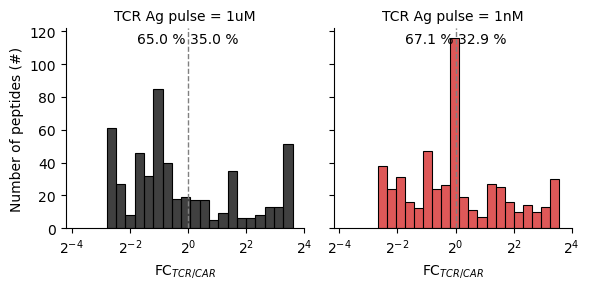

In [37]:
# Plotting the results
agdens_palette = {"1uM": perturb_palette["None"], "1nM": perturb_palette["AgDens"]}
nice_pulse_name = "TCR Ag pulse"
plotDf = np.log2(df_antagonism_mut["stats"])
new_lvl = "Antigen & mutation"
plotDf[new_lvl] = (plotDf.index.get_level_values("Antigen") 
                    + "-" + plotDf.index.get_level_values("Peptide"))
plotDf = plotDf.set_index(new_lvl, append=True)
plotDf = (plotDf.groupby([new_lvl, dens_name])  # Average across receptors
            .mean().sort_values("best")
         )
plotDf.index = plotDf.index.rename(names=nice_pulse_name, level=dens_name)
nice_fc_label = r"$\mathrm{FC}_{TCR/CAR}$"
plotDf = plotDf.rename(mapper={"best": nice_fc_label}, axis=1)

facet = sns.FacetGrid(
    data=plotDf.reset_index(), 
    hue=nice_pulse_name, 
    palette=agdens_palette, 
    hue_order=["1uM", "1nM"],
    col=nice_pulse_name, 
    col_order=["1uM", "1nM"],
)
facet.map(sns.histplot, nice_fc_label, bins=20)
#for ax in facet.axes.flat:
#    ax.axvline(0.0, ls="--", color="k", lw=1.0)
facet.fig.set_size_inches(facet.fig.get_size_inches()[0], facet.fig.get_size_inches()[1])
change_log_ticks(facet.axes.flat[0], which="x")
change_log_ticks(facet.axes.flat[1], which="x")

# Annotate with the fraction of antigens below FC = 1.0
pulse_concs = ["1uM", "1nM"]
for i in range(2):
    conc = pulse_concs[i]
    xlims =  facet.axes.flat[i].get_xlim()
    facet.axes.flat[i].set_xlim(xlims[0]-0.1, xlims[1])
    frac_below = (np.sum(df_antagonism_mut.xs(conc, level=dens_name)[("stats", "best")] < 1.0) 
                  / df_antagonism_mut.xs(conc, level=dens_name)[("stats", "best")].count())
    facet.axes.flat[i].axvline(0.0, ls="--", color="grey", lw=1.0)
    ymax = facet.axes.flat[i].get_ylim()[1]
    facet.axes.flat[i].annotate("{:.1f} %".format(100.0*frac_below), xy=(-0.075, ymax*.98), 
                                va="top", ha="right")
    facet.axes.flat[i].annotate("{:.1f} %".format(100.0*(1.0 - frac_below)), xy=(0.075, ymax*.98), 
                                va="top", ha="left")
facet.axes.flat[0].set_ylabel("Number of peptides (#)")

facet.figure.tight_layout()
if do_save_plots:
    facet.figure.savefig("figures/extra_predictions/mskcc_antagonism_fc_distributions_pc9.pdf", 
                      transparent=True, bbox_inches="tight")
plt.show()
plt.close()

In [38]:
# Compute the fraction of agonists, antagonists, null peptides for each TCR and antigen
df_pc9_samples = np.log2(df_antagonism_mut["samples"].xs("1uM", level=dens_name))
null_thresh = 1.0  # log2 fold-change
totals_peps = df_pc9_samples.groupby(["Antigen", "TCR"]).count()
df_fracs_samples = pd.concat({
    "agonists": (df_pc9_samples >= null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps, 
    "antagonists": (df_pc9_samples <= -null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps, 
    "null": (np.abs(df_pc9_samples) < null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps
}, names=["peptide_type"]).sort_index(level=["Antigen", "TCR"])
df_fracs_samples.columns = df_fracs_samples.columns.astype(np.int64)

df_antag_best = np.log2(df_antagonism_mut[("stats", "best")].xs("1uM", level=dens_name))
totals_peps_best = df_antag_best.groupby(["Antigen", "TCR"]).count()
df_fracs_best = pd.concat({
    "agonists": (df_antag_best >= null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps_best, 
    "antagonists": (df_antag_best <= -null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps_best, 
    "null": (np.abs(df_antag_best) < null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps_best
}, names=["peptide_type"]).sort_index(level=["Antigen", "TCR"])

# Compute statistics of agonist, antagonist, null fractions across MCMC samples (columns)
df_fracs_samples_stats = pd.concat({
    "mean": df_fracs_samples.mean(axis=1), 
    "median": df_fracs_samples.median(axis=1),
    "percentile_2.5": df_fracs_samples.quantile(q=0.025, axis=1), 
    "percentile_97.5": df_fracs_samples.quantile(q=0.975, axis=1), 
    "best": df_fracs_best
}, names=["stats"], axis=1)
df_fracs_samples_display = (df_fracs_samples_stats.unstack("peptide_type")
                .reorder_levels(["peptide_type", "stats"], axis=1).sort_index(axis=1))
df_fracs_samples_display

peptide_type    agonists                                                     \
stats               best      mean    median percentile_2.5 percentile_97.5   
Antigen    TCR                                                                
CMV        1    0.465116  0.456773  0.459302       0.430233        0.488372   
           2    0.418605  0.407581  0.406977       0.377907        0.430378   
           3    0.319767  0.322337  0.319767       0.302326        0.343023   
Neoantigen 7    0.273256  0.276122  0.273256       0.255814        0.302326   
gp100      4    0.110465  0.111087  0.110465       0.093023        0.127907   
           5    0.470930  0.473384  0.470930       0.453488        0.494186   
           6    0.215116  0.209721  0.209302       0.191860        0.226744   

peptide_type   antagonists                                                     \
stats                 best      mean    median percentile_2.5 percentile_97.5   
Antigen    TCR                                                                  
CMV        1      0.494186  0.462192  0.465116       0.424419        0.500000   
           2      0.563953  0.545570  0.546512       0.517442        0.563953   
           3      0.610465  0.593343  0.593023       0.540698        0.633721   
Neoantigen 7      0.517442  0.498901  0.482558       0.371948        0.627907   
gp100      4      0.860465  0.664529  0.645349       0.494041        0.843023   
           5      0.441860  0.385349  0.377907       0.302326        0.470930   
           6      0.773256  0.637872  0.627907       0.517442        0.761773   

peptide_type        null                                                     
stats               best      mean    median percentile_2.5 percentile_97.5  
Antigen    TCR                                                               
CMV        1    0.040698  0.081035  0.081395       0.046512        0.122093  
           2    0.017442  0.046849  0.046512       0.023256        0.075581  
           3    0.069767  0.084320  0.081395       0.040698        0.133721  
Neoantigen 7    0.209302  0.224977  0.238372       0.098837        0.348837  
gp100      4    0.029070  0.224384  0.244186       0.040698        0.401163  
           5    0.087209  0.141267  0.145349       0.058140        0.226744  
           6    0.011628  0.152407  0.162791       0.029070        0.279070

In [39]:
# Plot fractions vs WT peptide EC50
def plot_fractions(df_fracs_stats, df_logec50s_estim):
    fig, ax = plt.subplots()
    pep_idx = df_logec50s_estim.sort_values().index
    assert pep_idx.names == ["Antigen", "TCR"]
    x_vals = 1.0 / 10.0**df_logec50s_estim.loc[pep_idx]
    colmap = {"agonists": "xkcd:goldenrod", "antagonists": "purple", "null": "grey"}
    for kind in ["agonists", "antagonists", "null"]:
        y_vals = df_fracs_stats.loc[pep_idx, (kind, "median")]
        y_lower = (y_vals - df_fracs_stats.loc[pep_idx, (kind, "percentile_2.5")]).clip(lower=0.0)
        y_upper = (df_fracs_stats.loc[pep_idx, (kind, "percentile_97.5")] - y_vals).clip(lower=0.0)
        ax.errorbar(x_vals, y_vals, yerr=[y_lower, y_upper], color=colmap[kind], label=kind, lw=2.5)
        #ax.plot(x_vals, y_vals, color=colmap[kind], label=kind)
    for pep in pep_idx:
        ax.annotate(pep, (x_vals.loc[pep], y_vals.loc[pep]), fontsize=8)
    ax.set(xlabel=r"p${}^{\mathrm{WT}}$ 1/EC50 ($\mathrm{M^{-1}}$)", ylabel="Fraction", xscale="log")
    ax.legend()
    fig.tight_layout()
    return fig, ax
        

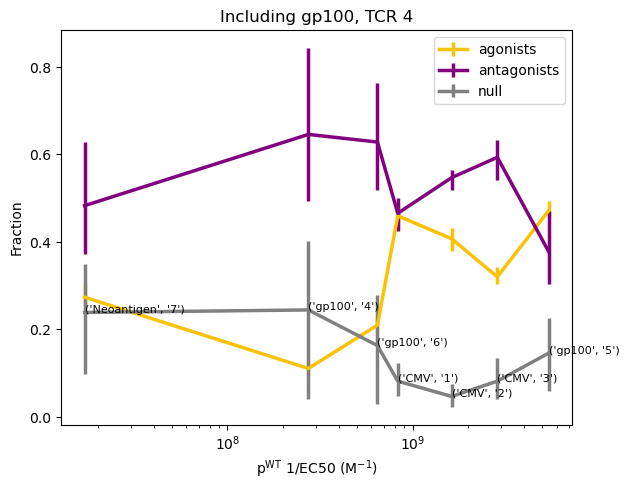

In [40]:
figax = plot_fractions(df_fracs_samples_display, df_logec50_info.xs("WT", level="Peptide")["estimator"])
figax[1].set_title("Including gp100, TCR 4")
plt.show()
plt.close()

# Also try without gp100, TCR 4 which has a lot of null (experimental issue?)
#figax = plot_fractions(df_fracs_samples_display.drop(("gp100", "4")), 
#        df_logec50_info.xs("WT", level="Peptide")["estimator"].drop(("gp100", "4")))
#figax[1].set_title("Without gp100, TCR 4")
#plt.show()
#plt.close()

In [41]:
# Save the predictions
if null_thresh > 0.25:
    res_file_name = os.path.join("results", "for_plots", 
        "mskcc_antagonism_fc_predictions_corrected_revised.h5")
else:
    res_file_name = os.path.join("results", "for_plots", 
        "mskcc_antagonism_fc_predictions_corrected_revised_nonull.h5")
if do_save_outputs:
    df_antagonism_mut["stats"].to_hdf(res_file_name, key="fc_stats")
    samples_df_to_save = df_antagonism_mut["samples"]
    samples_df_to_save.columns = samples_df_to_save.columns.astype(np.int64)
    samples_df_to_save.to_hdf(res_file_name, key="fc_samples")
    df_fracs_samples_stats.to_hdf(res_file_name, key="fracs_stats")
    df_fracs_samples.to_hdf(res_file_name, key="fracs_samples")
    df_ec50_stats_treat[[choice_method, choice_std]].to_hdf(res_file_name, key="EC50_fits")
    pep_logec50_samples.to_hdf(res_file_name, key="EC50_samples")
    print("Saved results")

Saved results
